Reload the normalized data to continue

😈 **Task 1:** What would happen if you skipped normalization before this step? Try reloading unnormalized data and compare.


In [1]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1ohReYdUgtBFogeAmxghPo3_Qa9RnzxSh/view?usp=drive_link 
# or if run locally you can load from the path as below:
# e.g. r"/content/timeseries_data/normalized_data.csv"
dataframes = pd.read_csv(r"/content/timeseries_data/normalized_data.csv")
variable_columns = ["no2", "temp", "o3", "no", "press"]
dataframes.shape

(702894, 9)

## Pre-processed Data analysis
The data can now be analysed for basic statistical tendencies or measures and then timeseries specific trends and anamolies

😈 **Question 1:** What is the difference between analyzing statistical features and timeseries patterns?


### **Timeseries Data Analysis and Anomaly Detection**
Since we know the data is a timeseries, we can analyse for seasonality, trends, and anomalies. such as:
- **Temporal Seasonality:** Decomposing the time series into trend, seasonality, and residuals.
- **Rolling Statistics:** Checking for stationarity.
- **Autocorrelation (ACF, PACF):** Identifying patterns in the data.
- **Anomaly Detection:** Using Z-score and visualizing anamolies.


😈 **Task 2:** Which variable besides `o3` might show seasonality? Try visualizing it.

😈 **Question 2:** How do stationarity and autocorrelation relate to model selection in ML?


#### Housekeeping: Initial setup and declarations


😈 **Task 3:** Add exception handling for missing packages and create a reusable setup cell.


In [5]:
!pip install seaborn matplotlib statsmodels

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.8 MB 7.5 MB/s eta 0:00:02
   ------------------ --------------------- 4.5/9.8 MB 8.4 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.8 MB 8.8 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.8 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 7.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
station_sample = 'DENW094'
variable_sample = 'o3'
# Filter data for the selected samples
df_station = dataframes[dataframes["station_code"] == station_sample]

#### Visualizing initial data before trends
 Select a station and variable for analysis o3 is picked here to identify seasonalities for comparison with multivariate but feel free to experiment with other variables and analyse the trends

😈 **Task 4:** Replace `o3` with `no2` and visualize the difference in seasonal patterns.


Plot the original timeseries

😈 **Task 5:** Overlay multiple variables from the same station to compare them directly.


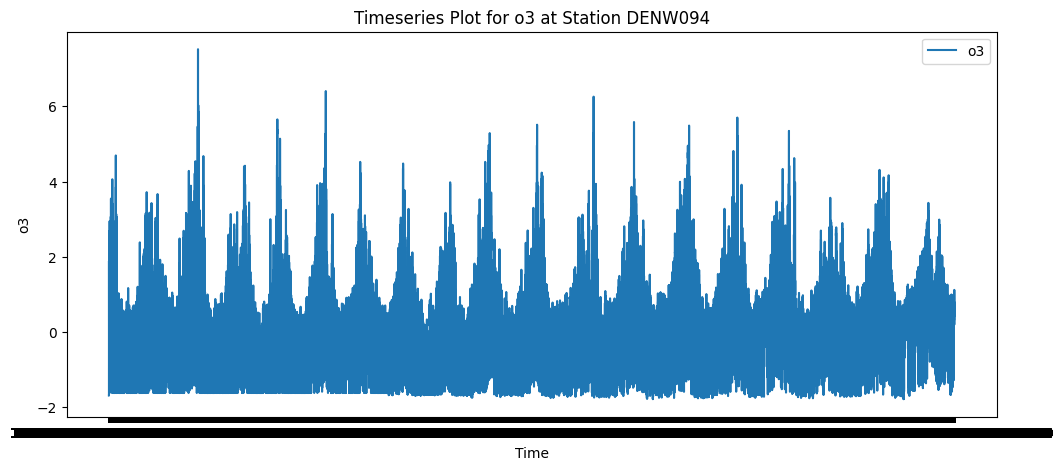

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df_station["datetime"], df_station[variable_sample], label=variable_sample)
plt.xlabel("Time")
plt.ylabel(variable_sample)
plt.title(f"Timeseries Plot for {variable_sample} at Station {station_sample}")
plt.legend()
plt.show()

#### Temporal Seasonality
Here is a simple sample seasonal decomposition, you can experiment with modifying the period and other seasonalities

😈 **Task 6:** Change the `period` parameter. What happens to the seasonality and trend components?


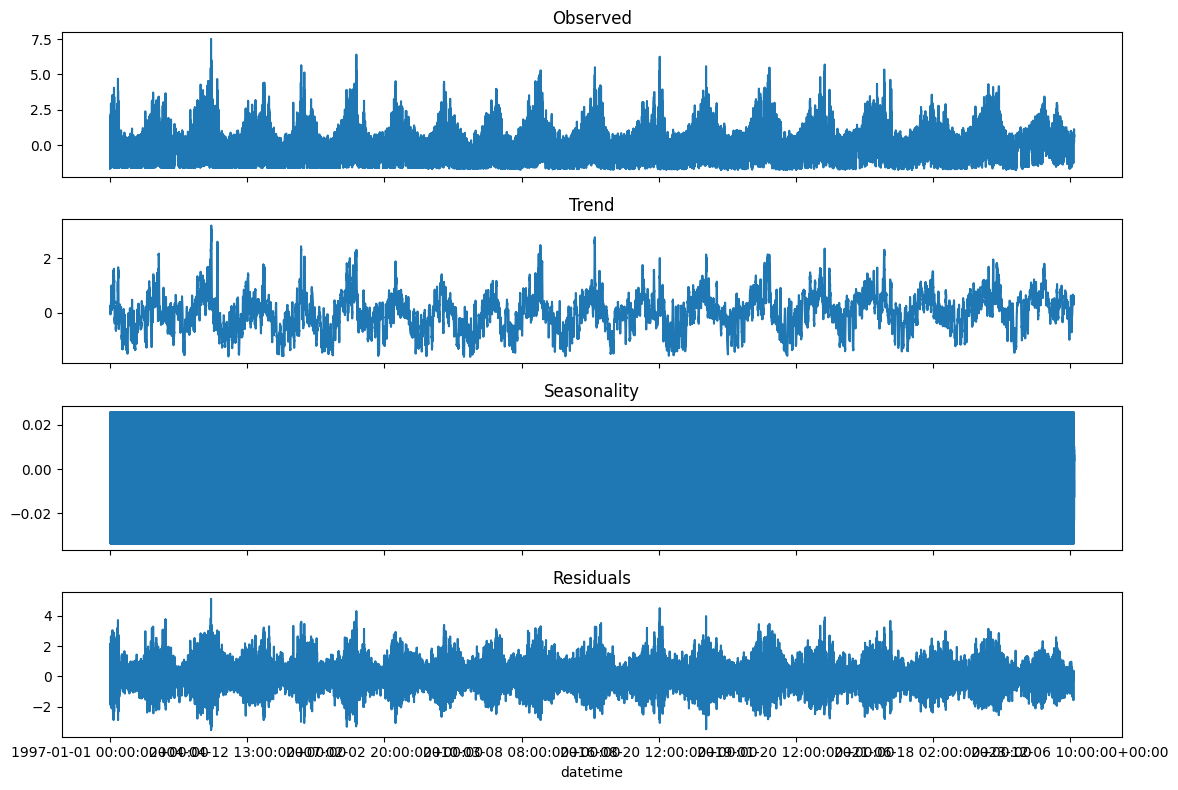

In [9]:
# Decompose the time series
decomposition = seasonal_decompose(df_station.set_index("datetime")[variable_sample], period=365, model='additive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals")
plt.tight_layout()
plt.show()

#### Rolling Statistics Analysis

Below is a sample function using adfuller method from stats_model package used for visualizing stationarity in the o3 of the sample station

😈 **Task 7:** Apply this to other variables. Does `no2` or `temp` appear more stationary?


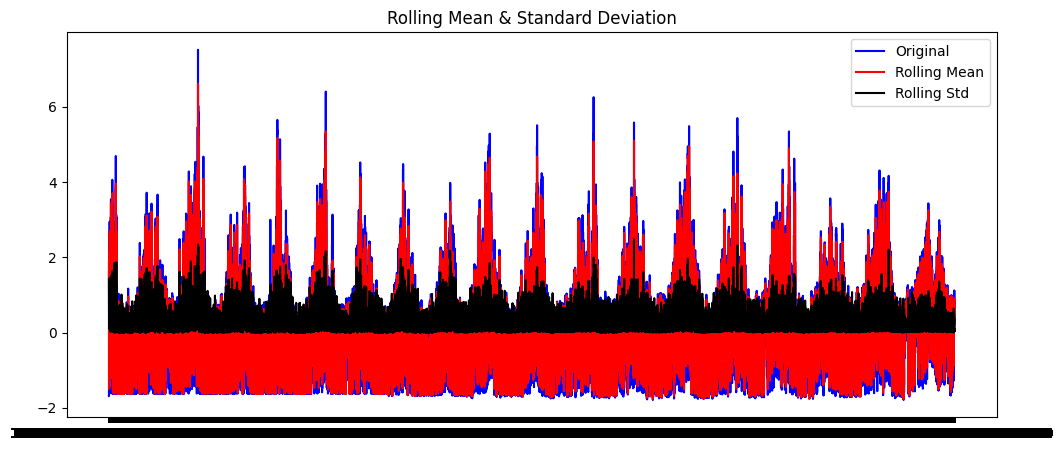

In [10]:
def plot_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    plt.figure(figsize=(12,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()


plot_stationarity(df_station.set_index("datetime")[variable_sample])

Below snippet uses ADF (Augmented Dickey-Fuller) test checks if a time series is stationary (constant mean and variance over time). In Moving Average models, p (AutoRegressive lags), d (number of differences for stationarity), and q (Moving Average lags) help capture trends and fluctuations—stationarity ensures that past patterns remain predictive for future values. AIC (Akaike Information Criterion) measures the goodness of fit of a model while penalizing complexity. In MA models, it helps select the best combination of p, d, q by balancing model accuracy and simplicity—lower AIC values indicate a better model as illustrated later on.

😈 **Question 3:** Why is low AIC important in model selection?

😈 **Task 8:** Apply grid search for AIC using different `p`, `d`, `q` combinations.


In [4]:
adf_test = adfuller(df_station.set_index("datetime")[variable_sample].dropna(), autolag='AIC')
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"P-Value: {adf_test[1]}")
print("Critical Values:", adf_test[4])
print("Stationary" if adf_test[1] < 0.05 else "Not Stationary")

ADF Test Statistic: -28.225005953187225
P-Value: 0.0
Critical Values: {'1%': np.float64(-3.43035930489765), '5%': np.float64(-2.8615441126578545), '10%': np.float64(-2.5667721890170894)}
Stationary


#### Correlation analysis

A simple *auto correlation* on the variable would indicate trend repetion ability of the time series in itself

😈 **Task 9:** Use PACF alongside ACF. How do they differ in interpretation?


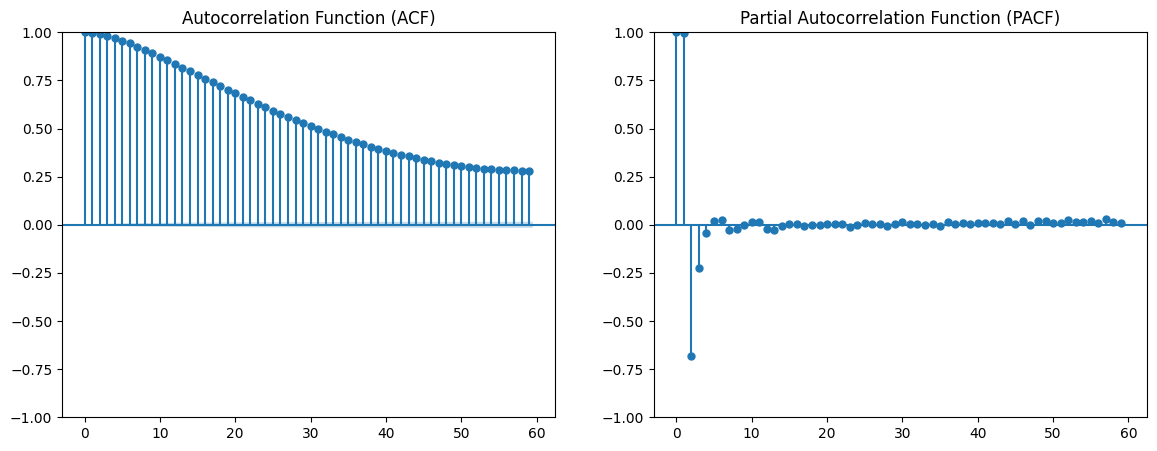

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_station.set_index("datetime")[variable_sample].dropna(), ax=ax[0])
plot_pacf(df_station.set_index("datetime")[variable_sample].dropna(), ax=ax[1])
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

#### Analomaly detection using Z-score

Normalized data over a chosen threshold (say 3) is visualized

😈 **Task 10:** Modify the threshold and see how anomaly count changes.

😈 **Question 4:** How might anomalies affect model training?



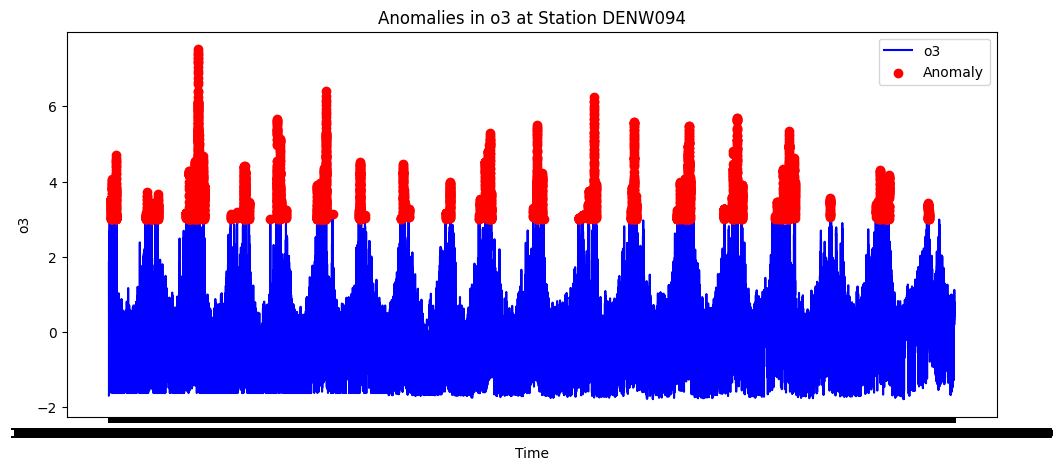

In [14]:
from scipy.stats import zscore

# Compute Z-scores
df_station = df_station.copy()
df_station.loc[:, "zscore"] = zscore(df_station[variable_sample], nan_policy='omit')

# Sample threshold for anomalies (|Z-score| > 3)
threshold = 3
df_anomalies = df_station[np.abs(df_station["zscore"]) > threshold]

# Plot anomalies
plt.figure(figsize=(12, 5))
plt.plot(df_station["datetime"], df_station[variable_sample], label=variable_sample, color='blue')
plt.scatter(df_anomalies["datetime"], df_anomalies[variable_sample], color='red', label="Anomaly", zorder=3)
plt.xlabel("Time")
plt.ylabel(variable_sample)
plt.title(f"Anomalies in {variable_sample} at Station {station_sample}")
plt.legend()
plt.show()


The values of anamolies above chosen sample 4 are listed below the idea is now for ML approaches to not just capture the above trends also handle the challenge of finding any underlying patterns to generalize well to accoung for these extremities.

😈 **Task 11:** Design a function to flag and replace anomalies with interpolated values or rolling mean.
😈 **Question 5:** How can anomaly detection improve generalization in ML models?


In [15]:
from IPython.display import display

# Display the detected anomalies
print("Anomalies Detected:")
display(df_anomalies)

Anomalies Detected:


,datetime,station_code,latitude,longitude,o3,no2,no,temp,press,zscore
1556,1999-07-24 18:00:00+00:00,DENW094,50.754704,6.093923,3.001352,-0.779999,-0.010652,1.992009,0.653820,3.001354
1557,1999-07-24 18:00:00+00:00,DENW094,50.754704,6.093923,3.015039,-0.779999,-0.010652,1.992009,0.643625,3.015041
1558,1999-07-24 18:00:00+00:00,DENW094,50.754704,6.093923,3.028727,-0.730655,-0.010652,1.992009,0.633431,3.028729
1559,1999-07-24 18:00:00+00:00,DENW094,50.754704,6.093923,3.042415,-0.681311,-0.010652,1.992009,0.623236,3.042417
1560,1999-07-24 18:00:00+00:00,DENW094,50.754704,6.093923,3.056102,-0.631967,-0.010652,1.978566,0.613042,3.056104
...,...,...,...,...,...,...,...,...,...,...
681319,2023-06-18 14:00:00+00:00,DENW094,50.754704,6.093923,3.073465,-0.716707,-0.357940,2.220669,-0.484813,3.073467
681320,2023-06-18 15:00:00+00:00,DENW094,50.754704,6.093923,3.049121,-0.723105,-0.354276,2.237203,-0.499718,3.049124
681321,2023-06-18 15:00:00+00:00,DENW094,50.754704,6.093923,3.011576,-0.729504,-0.350611,2.253738,-0.514622,3.011578
681334,2023-06-18 17:00:00+00:00,DENW094,50.754704,6.093923,3.009195,-0.248106,-0.356315,2.000236,-0.594609,3.009197
